This code uses a pretrained transformer as proposed on this website:

https://huggingface.co/docs/transformers/tasks/audio_classification#train

In [1]:
from lib_util import utils
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from datasets import DatasetDict, Dataset

config = utils.get_config('wav2vec2')

audio_data = utils.load_sliced_numpy_array('preprocessed_data')
labels = np.load('data/labels.npy')

labels_to_id = utils.get_class_mapping()

audiodata_train, audiodata_test_val, lab_train, lab_test_val = train_test_split(audio_data, labels, train_size=config['train_set_size'], random_state=config['random_state'])
audiodata_val, audiodata_test, lab_val, lab_test             = train_test_split(audiodata_test_val, lab_test_val, test_size=(config['val_set_size']/(1-config['train_set_size'])), shuffle=False)

# Check the shapes of the splitted sets
assert audiodata_train.shape[0] == lab_train.shape[0] and audiodata_test.shape[0] == lab_test.shape[0] and audiodata_val.shape[0] == lab_val.shape[0]
assert audiodata_train.shape[1] == audiodata_test.shape[1] == audiodata_val.shape[1] and lab_train.shape[1] == lab_test.shape[1] == lab_val.shape[1]


2023-01-24 16:23:54.472971: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/mstuffer/.pyenv/versions/3.9.15/envs/ai-industry/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load slice from file preprocessed_data_001.npy
Load slice from file preprocessed_data_002.npy
Load slice from file preprocessed_data_003.npy
Load slice from file preprocessed_data_004.npy
Load slice from file preprocessed_data_005.npy
Load slice from file preprocessed_data_006.npy
Load slice from file preprocessed_data_007.npy
Load slice from file preprocessed_data_008.npy
Load slice from file preprocessed_data_009.npy
Loaded 9 files as slices, resulting shape: (4068, 48000)


In [2]:
np.unique(np.argmax(lab_train, axis=1), return_counts=True)

(array([0, 1, 2, 3, 4]), array([602, 469, 691, 652, 433]))

In [3]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(config['pretrained_feature_extractor'])

/Users/mstuffer/.pyenv/versions/3.9.15/envs/ai-industry/lib/python3.9/site-packages/transformers/configuration_utils.py:369: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [4]:
pp_config = utils.get_config('preprocess')
unique_sample_rate = pp_config['downsample_rate']
unique_audio_length = pp_config['unit_length_ms']

list_of_dict = lambda X, y: [{'audio':{'array': audio, 'sampling_rate': unique_sample_rate}, 'label': y[i]} for i, audio in enumerate(X)]

dataset = DatasetDict(
    {
        'train': Dataset.from_list(list_of_dict(audiodata_train, np.argmax(lab_train, axis=1))),
        'val': Dataset.from_list(list_of_dict(audiodata_val, np.argmax(lab_val, axis=1))),
        'test': Dataset.from_list(list_of_dict(audiodata_test, np.argmax(lab_test, axis=1)))
    }
)

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 2847
    })
    val: Dataset({
        features: ['audio', 'label'],
        num_rows: 610
    })
    test: Dataset({
        features: ['audio', 'label'],
        num_rows: 611
    })
})

In [6]:
dataset['train'][0]

{'audio': {'array': [0.0026233582757413387,
   0.004362966865301132,
   0.0038998625241219997,
   0.004303396679461002,
   0.004175532143563032,
   0.004395530093461275,
   0.004404778126627207,
   0.004517446272075176,
   0.004570853430777788,
   0.004637016449123621,
   0.004738328047096729,
   0.004773761611431837,
   0.00489388033747673,
   0.004911590367555618,
   0.005029433406889439,
   0.005064362194389105,
   0.0051359073258936405,
   0.005180885549634695,
   0.005260151345282793,
   0.005313378293067217,
   0.00537985609844327,
   0.005418767221271992,
   0.00544849643483758,
   0.005501572974026203,
   0.005537653341889381,
   0.0055895112454891205,
   0.005637412425130606,
   0.0056458404287695885,
   0.005657922010868788,
   0.005702391266822815,
   0.00570892496034503,
   0.0057307397946715355,
   0.005735378246754408,
   0.005733022000640631,
   0.0057385265827178955,
   0.005751576274633408,
   0.005739755928516388,
   0.0057236384600400925,
   0.005744699854403734,
   

In [7]:
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays, sampling_rate=feature_extractor.sampling_rate, max_length=unique_sample_rate*unique_audio_length/1000, truncation=True
    )
    return inputs

encoded_dataset = dataset.map(preprocess_function, remove_columns="audio", batched=True)

100%|██████████| 1/1 [00:16<00:00, 16.41s/ba]


In [8]:
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

print(labels_to_id)
id_to_labels = {}
for key in labels_to_id:
    id_to_labels[labels_to_id[key]] = key
print(id_to_labels)

num_labels = len(labels_to_id)
model = AutoModelForAudioClassification.from_pretrained(
    config['pretrained_transformer_classificator'], num_labels=num_labels, label2id=labels_to_id, id2label=id_to_labels
)

{'06 Deep House': 0, '09 Disco Funk': 1, '12 Chinese Traditional': 2, '15 Reggaeton Pop': 3, 'Keyboard Collection': 4}
{0: '06 Deep House', 1: '09 Disco Funk', 2: '12 Chinese Traditional', 3: '15 Reggaeton Pop', 4: 'Keyboard Collection'}


/Users/mstuffer/.pyenv/versions/3.9.15/envs/ai-industry/lib/python3.9/site-packages/transformers/configuration_utils.py:369: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2ForSequenceClassification: ['project_q.weight', 'project_hid.weight', 'quantizer.codevectors', 'quantizer.weight_proj.bias', 'quantizer.weight_proj.weight', 'project_q.bias', 'project_hid.bias']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected 

In [9]:
training_conf = config['training']

training_args = TrainingArguments(
    output_dir=config['output_dir'],
    evaluation_strategy=training_conf['eval_strategy'],
    save_strategy=training_conf['save_strategy'],
    learning_rate=training_conf['learning_rate'],
    per_device_train_batch_size=training_conf['train_batch_size'],
    gradient_accumulation_steps=training_conf['gradient_accumulation_steps'],
    per_device_eval_batch_size=training_conf['eval_batch_size'],
    num_train_epochs=training_conf['num_train_epochs'],
    warmup_ratio=training_conf['warmup_ratio'],
    logging_steps=training_conf['logging_steps'],
    load_best_model_at_end=training_conf['load_best_model_at_end'],
    metric_for_best_model=training_conf['metric_for_best_model'],
    push_to_hub=False
)

In [10]:
import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=eval_pred.label_ids)

In [11]:
from transformers.trainer_callback import EarlyStoppingCallback

es = EarlyStoppingCallback(
    early_stopping_patience=training_conf['early_stopping_patience'],
)

In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['val'],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    callbacks=[es]
)

trainer.train()

/Users/mstuffer/.pyenv/versions/3.9.15/envs/ai-industry/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2847
  Num Epochs = 20
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 440
  Number of trainable parameters = 94569861
  1%|          | 5/440 [10:37<15:35:00, 128.97s/it]

{'loss': 1.5989, 'learning_rate': 3.4090909090909085e-05, 'epoch': 0.22}


  2%|▏         | 10/440 [20:03<13:29:25, 112.94s/it]

{'loss': 1.533, 'learning_rate': 6.818181818181817e-05, 'epoch': 0.45}


  3%|▎         | 15/440 [28:18<11:47:21, 99.86s/it] 

{'loss': 1.4066, 'learning_rate': 0.00010227272727272726, 'epoch': 0.67}


  5%|▍         | 20/440 [36:16<11:14:49, 96.40s/it]

{'loss': 1.3131, 'learning_rate': 0.00013636363636363634, 'epoch': 0.9}


  5%|▌         | 22/440 [39:27<11:08:57, 96.02s/it]***** Running Evaluation *****
  Num examples = 610
  Batch size = 32
                                                   
  5%|▌         | 22/440 [41:51<11:08:57, 96.02s/it]Saving model checkpoint to models/huggingface/checkpoint-22
Configuration saved in models/huggingface/checkpoint-22/config.json


{'eval_loss': 1.2583774328231812, 'eval_accuracy': 0.5278688524590164, 'eval_runtime': 120.9126, 'eval_samples_per_second': 5.045, 'eval_steps_per_second': 0.165, 'epoch': 0.99}


Model weights saved in models/huggingface/checkpoint-22/pytorch_model.bin
Feature extractor saved in models/huggingface/checkpoint-22/preprocessor_config.json
  6%|▌         | 25/440 [46:42<13:32:42, 117.50s/it]

{'loss': 1.2599, 'learning_rate': 0.00017045454545454547, 'epoch': 1.13}


  7%|▋         | 30/440 [54:42<11:21:36, 99.75s/it] 

{'loss': 1.0912, 'learning_rate': 0.0002045454545454545, 'epoch': 1.36}


  8%|▊         | 35/440 [1:02:44<10:53:57, 96.88s/it]

{'loss': 1.0859, 'learning_rate': 0.0002386363636363636, 'epoch': 1.58}


  9%|▉         | 40/440 [1:10:47<10:44:09, 96.62s/it]

{'loss': 1.0642, 'learning_rate': 0.0002727272727272727, 'epoch': 1.81}


 10%|█         | 44/440 [1:17:14<10:38:30, 96.74s/it]***** Running Evaluation *****
  Num examples = 610
  Batch size = 32
                                                     
 10%|█         | 44/440 [1:19:41<10:38:30, 96.74s/it]Saving model checkpoint to models/huggingface/checkpoint-44
Configuration saved in models/huggingface/checkpoint-44/config.json


{'eval_loss': 1.1302337646484375, 'eval_accuracy': 0.5836065573770491, 'eval_runtime': 121.5194, 'eval_samples_per_second': 5.02, 'eval_steps_per_second': 0.165, 'epoch': 1.99}


Model weights saved in models/huggingface/checkpoint-44/pytorch_model.bin
Feature extractor saved in models/huggingface/checkpoint-44/preprocessor_config.json
 10%|█         | 45/440 [1:21:21<15:32:16, 141.61s/it]

{'loss': 1.1483, 'learning_rate': 0.00029924242424242425, 'epoch': 2.04}


 11%|█▏        | 50/440 [1:29:25<11:18:18, 104.36s/it]

{'loss': 0.9946, 'learning_rate': 0.0002954545454545454, 'epoch': 2.27}


 12%|█▎        | 55/440 [1:37:29<10:29:34, 98.12s/it] 

{'loss': 1.0285, 'learning_rate': 0.00029166666666666664, 'epoch': 2.49}


 14%|█▎        | 60/440 [1:45:34<10:15:40, 97.21s/it]

{'loss': 0.9942, 'learning_rate': 0.00028787878787878786, 'epoch': 2.72}


 15%|█▍        | 65/440 [1:53:41<10:09:03, 97.45s/it]

{'loss': 0.8994, 'learning_rate': 0.0002840909090909091, 'epoch': 2.94}


 15%|█▌        | 66/440 [1:55:18<10:06:25, 97.29s/it]***** Running Evaluation *****
  Num examples = 610
  Batch size = 32
                                                     
 15%|█▌        | 66/440 [1:57:44<10:06:25, 97.29s/it]Saving model checkpoint to models/huggingface/checkpoint-66
Configuration saved in models/huggingface/checkpoint-66/config.json


{'eval_loss': 0.9348214864730835, 'eval_accuracy': 0.660655737704918, 'eval_runtime': 122.5721, 'eval_samples_per_second': 4.977, 'eval_steps_per_second': 0.163, 'epoch': 2.99}


Model weights saved in models/huggingface/checkpoint-66/pytorch_model.bin
Feature extractor saved in models/huggingface/checkpoint-66/preprocessor_config.json
 16%|█▌        | 70/440 [2:04:17<11:34:24, 112.61s/it]

{'loss': 0.8753, 'learning_rate': 0.0002803030303030303, 'epoch': 3.18}


 17%|█▋        | 75/440 [2:12:24<10:08:03, 99.95s/it] 

{'loss': 0.7287, 'learning_rate': 0.00027651515151515146, 'epoch': 3.4}


 18%|█▊        | 80/440 [2:20:49<10:11:23, 101.90s/it]

{'loss': 0.7403, 'learning_rate': 0.0002727272727272727, 'epoch': 3.63}


 19%|█▉        | 85/440 [2:29:24<10:08:56, 102.92s/it]

{'loss': 0.7938, 'learning_rate': 0.00026893939393939396, 'epoch': 3.85}


 20%|██        | 88/440 [2:34:32<10:01:20, 102.50s/it]***** Running Evaluation *****
  Num examples = 610
  Batch size = 32
                                                      
 20%|██        | 88/440 [2:37:06<10:01:20, 102.50s/it]Saving model checkpoint to models/huggingface/checkpoint-88
Configuration saved in models/huggingface/checkpoint-88/config.json


{'eval_loss': 0.8203856348991394, 'eval_accuracy': 0.6983606557377049, 'eval_runtime': 128.2908, 'eval_samples_per_second': 4.755, 'eval_steps_per_second': 0.156, 'epoch': 3.99}


Model weights saved in models/huggingface/checkpoint-88/pytorch_model.bin
Feature extractor saved in models/huggingface/checkpoint-88/preprocessor_config.json
 20%|██        | 90/440 [2:40:36<13:15:19, 136.34s/it]

{'loss': 0.6684, 'learning_rate': 0.0002651515151515151, 'epoch': 4.09}


 22%|██▏       | 95/440 [2:49:44<10:59:37, 114.72s/it]

{'loss': 0.6237, 'learning_rate': 0.00026136363636363634, 'epoch': 4.31}


 23%|██▎       | 100/440 [2:59:05<10:37:22, 112.48s/it]

{'loss': 0.635, 'learning_rate': 0.00025757575757575756, 'epoch': 4.54}


 24%|██▍       | 105/440 [3:08:28<10:30:45, 112.97s/it]

{'loss': 0.6202, 'learning_rate': 0.00025378787878787873, 'epoch': 4.76}


 25%|██▌       | 110/440 [3:18:01<10:28:14, 114.22s/it]

{'loss': 0.5199, 'learning_rate': 0.00025, 'epoch': 4.99}


***** Running Evaluation *****
  Num examples = 610
  Batch size = 32
                                                       
 25%|██▌       | 110/440 [3:20:50<10:28:14, 114.22s/it]Saving model checkpoint to models/huggingface/checkpoint-110
Configuration saved in models/huggingface/checkpoint-110/config.json


{'eval_loss': 0.6394803524017334, 'eval_accuracy': 0.7852459016393443, 'eval_runtime': 141.5931, 'eval_samples_per_second': 4.308, 'eval_steps_per_second': 0.141, 'epoch': 4.99}


Model weights saved in models/huggingface/checkpoint-110/pytorch_model.bin
Feature extractor saved in models/huggingface/checkpoint-110/preprocessor_config.json
 26%|██▌       | 115/440 [3:30:51<11:51:08, 131.29s/it]

{'loss': 0.5533, 'learning_rate': 0.00024621212121212117, 'epoch': 5.22}


 27%|██▋       | 120/440 [3:40:16<10:06:19, 113.69s/it]

{'loss': 0.549, 'learning_rate': 0.0002424242424242424, 'epoch': 5.45}


 28%|██▊       | 125/440 [3:49:01<9:19:20, 106.54s/it] 

{'loss': 0.3901, 'learning_rate': 0.0002386363636363636, 'epoch': 5.67}


 30%|██▉       | 130/440 [3:57:27<8:48:07, 102.22s/it]

{'loss': 0.4952, 'learning_rate': 0.00023484848484848483, 'epoch': 5.9}


 30%|███       | 132/440 [4:00:59<8:55:26, 104.31s/it]***** Running Evaluation *****
  Num examples = 610
  Batch size = 32
                                                      
 30%|███       | 132/440 [4:03:38<8:55:26, 104.31s/it]Saving model checkpoint to models/huggingface/checkpoint-132
Configuration saved in models/huggingface/checkpoint-132/config.json


{'eval_loss': 0.5903735756874084, 'eval_accuracy': 0.8098360655737705, 'eval_runtime': 132.8145, 'eval_samples_per_second': 4.593, 'eval_steps_per_second': 0.151, 'epoch': 5.99}


Model weights saved in models/huggingface/checkpoint-132/pytorch_model.bin
Feature extractor saved in models/huggingface/checkpoint-132/preprocessor_config.json
 31%|███       | 135/440 [4:09:07<11:03:55, 130.61s/it]

{'loss': 0.4498, 'learning_rate': 0.00023106060606060605, 'epoch': 6.13}


 32%|███▏      | 140/440 [4:18:07<9:21:45, 112.35s/it] 

{'loss': 0.4451, 'learning_rate': 0.00022727272727272725, 'epoch': 6.36}


 33%|███▎      | 145/440 [4:26:57<8:46:45, 107.14s/it]

{'loss': 0.3646, 'learning_rate': 0.00022348484848484847, 'epoch': 6.58}


 34%|███▍      | 150/440 [4:35:10<8:02:44, 99.88s/it] 

{'loss': 0.3963, 'learning_rate': 0.00021969696969696969, 'epoch': 6.81}


 35%|███▌      | 154/440 [4:41:42<7:49:12, 98.43s/it]***** Running Evaluation *****
  Num examples = 610
  Batch size = 32
                                                     
 35%|███▌      | 154/440 [4:44:08<7:49:12, 98.43s/it]Saving model checkpoint to models/huggingface/checkpoint-154
Configuration saved in models/huggingface/checkpoint-154/config.json


{'eval_loss': 0.708118736743927, 'eval_accuracy': 0.7852459016393443, 'eval_runtime': 122.7407, 'eval_samples_per_second': 4.97, 'eval_steps_per_second': 0.163, 'epoch': 6.99}


Model weights saved in models/huggingface/checkpoint-154/pytorch_model.bin
Feature extractor saved in models/huggingface/checkpoint-154/preprocessor_config.json
 35%|███▌      | 155/440 [4:45:50<11:20:40, 143.30s/it]

{'loss': 0.5919, 'learning_rate': 0.0002159090909090909, 'epoch': 7.04}


 36%|███▋      | 160/440 [4:54:03<8:15:31, 106.19s/it] 

{'loss': 0.4026, 'learning_rate': 0.0002121212121212121, 'epoch': 7.27}


 38%|███▊      | 165/440 [5:02:18<7:38:59, 100.14s/it]

{'loss': 0.383, 'learning_rate': 0.00020833333333333332, 'epoch': 7.49}


 39%|███▊      | 170/440 [5:10:34<7:27:39, 99.48s/it] 

{'loss': 0.3244, 'learning_rate': 0.0002045454545454545, 'epoch': 7.72}


 40%|███▉      | 175/440 [5:19:18<7:43:36, 104.97s/it]

{'loss': 0.3894, 'learning_rate': 0.00020075757575757576, 'epoch': 7.94}


 40%|████      | 176/440 [5:21:05<7:44:42, 105.62s/it]***** Running Evaluation *****
  Num examples = 610
  Batch size = 32
                                                      
 40%|████      | 176/440 [5:23:44<7:44:42, 105.62s/it]Saving model checkpoint to models/huggingface/checkpoint-176
Configuration saved in models/huggingface/checkpoint-176/config.json


{'eval_loss': 0.6389170289039612, 'eval_accuracy': 0.8032786885245902, 'eval_runtime': 133.6671, 'eval_samples_per_second': 4.564, 'eval_steps_per_second': 0.15, 'epoch': 7.99}


Model weights saved in models/huggingface/checkpoint-176/pytorch_model.bin
Feature extractor saved in models/huggingface/checkpoint-176/preprocessor_config.json
 41%|████      | 180/440 [5:30:31<8:32:03, 118.17s/it] 

{'loss': 0.4177, 'learning_rate': 0.00019696969696969695, 'epoch': 8.18}


 42%|████▏     | 185/440 [5:38:48<7:15:43, 102.52s/it]

{'loss': 0.266, 'learning_rate': 0.00019318181818181815, 'epoch': 8.4}


 43%|████▎     | 190/440 [5:47:06<6:57:22, 100.17s/it]

{'loss': 0.2608, 'learning_rate': 0.00018939393939393937, 'epoch': 8.63}


 44%|████▍     | 195/440 [5:55:22<6:46:05, 99.45s/it] 

{'loss': 0.2701, 'learning_rate': 0.00018560606060606061, 'epoch': 8.85}


 45%|████▌     | 198/440 [6:00:21<6:41:19, 99.50s/it]***** Running Evaluation *****
  Num examples = 610
  Batch size = 32
                                                     
 45%|████▌     | 198/440 [6:02:49<6:41:19, 99.50s/it]Saving model checkpoint to models/huggingface/checkpoint-198
Configuration saved in models/huggingface/checkpoint-198/config.json


{'eval_loss': 0.43720918893814087, 'eval_accuracy': 0.8524590163934426, 'eval_runtime': 124.1362, 'eval_samples_per_second': 4.914, 'eval_steps_per_second': 0.161, 'epoch': 8.99}


Model weights saved in models/huggingface/checkpoint-198/pytorch_model.bin
Feature extractor saved in models/huggingface/checkpoint-198/preprocessor_config.json
 45%|████▌     | 200/440 [6:06:11<8:44:26, 131.11s/it]

{'loss': 0.2733, 'learning_rate': 0.0001818181818181818, 'epoch': 9.09}


 47%|████▋     | 205/440 [6:14:26<6:49:32, 104.57s/it]

{'loss': 0.2335, 'learning_rate': 0.000178030303030303, 'epoch': 9.31}


 48%|████▊     | 210/440 [6:22:44<6:24:25, 100.28s/it]

{'loss': 0.1904, 'learning_rate': 0.00017424242424242422, 'epoch': 9.54}


 49%|████▉     | 215/440 [6:31:00<6:12:51, 99.43s/it] 

{'loss': 0.1617, 'learning_rate': 0.00017045454545454547, 'epoch': 9.76}


 50%|█████     | 220/440 [6:39:17<6:04:27, 99.40s/it]

{'loss': 0.2573, 'learning_rate': 0.00016666666666666666, 'epoch': 9.99}


***** Running Evaluation *****
  Num examples = 610
  Batch size = 32
                                                     
 50%|█████     | 220/440 [6:41:45<6:04:27, 99.40s/it]Saving model checkpoint to models/huggingface/checkpoint-220
Configuration saved in models/huggingface/checkpoint-220/config.json


{'eval_loss': 0.5539265871047974, 'eval_accuracy': 0.8426229508196721, 'eval_runtime': 124.1403, 'eval_samples_per_second': 4.914, 'eval_steps_per_second': 0.161, 'epoch': 9.99}


Model weights saved in models/huggingface/checkpoint-220/pytorch_model.bin
Feature extractor saved in models/huggingface/checkpoint-220/preprocessor_config.json
 51%|█████     | 225/440 [6:50:04<6:34:17, 110.04s/it]

{'loss': 0.2364, 'learning_rate': 0.00016287878787878785, 'epoch': 10.22}


 52%|█████▏    | 230/440 [6:58:22<5:54:43, 101.35s/it]

{'loss': 0.2039, 'learning_rate': 0.00015909090909090907, 'epoch': 10.45}


 53%|█████▎    | 235/440 [7:06:39<5:40:44, 99.73s/it] 

{'loss': 0.1615, 'learning_rate': 0.00015530303030303027, 'epoch': 10.67}


 55%|█████▍    | 240/440 [7:14:56<5:32:16, 99.68s/it]

{'loss': 0.1773, 'learning_rate': 0.00015151515151515152, 'epoch': 10.9}


 55%|█████▌    | 242/440 [7:18:16<5:29:01, 99.71s/it]***** Running Evaluation *****
  Num examples = 610
  Batch size = 32
                                                     
 55%|█████▌    | 242/440 [7:20:43<5:29:01, 99.71s/it]Saving model checkpoint to models/huggingface/checkpoint-242
Configuration saved in models/huggingface/checkpoint-242/config.json


{'eval_loss': 0.4948076009750366, 'eval_accuracy': 0.8459016393442623, 'eval_runtime': 123.541, 'eval_samples_per_second': 4.938, 'eval_steps_per_second': 0.162, 'epoch': 10.99}


Model weights saved in models/huggingface/checkpoint-242/pytorch_model.bin
Feature extractor saved in models/huggingface/checkpoint-242/preprocessor_config.json
 56%|█████▌    | 245/440 [7:25:43<6:34:30, 121.39s/it]

{'loss': 0.2053, 'learning_rate': 0.0001477272727272727, 'epoch': 11.13}


 57%|█████▋    | 250/440 [7:33:59<5:25:58, 102.94s/it]

{'loss': 0.1325, 'learning_rate': 0.00014393939393939393, 'epoch': 11.36}


 58%|█████▊    | 255/440 [7:42:15<5:07:55, 99.87s/it] 

{'loss': 0.137, 'learning_rate': 0.00014015151515151515, 'epoch': 11.58}


 59%|█████▉    | 260/440 [7:50:31<4:57:26, 99.15s/it]

{'loss': 0.1005, 'learning_rate': 0.00013636363636363634, 'epoch': 11.81}


 60%|██████    | 264/440 [7:57:07<4:50:35, 99.07s/it]***** Running Evaluation *****
  Num examples = 610
  Batch size = 32
                                                     
 60%|██████    | 264/440 [7:59:35<4:50:35, 99.07s/it]Saving model checkpoint to models/huggingface/checkpoint-264
Configuration saved in models/huggingface/checkpoint-264/config.json


{'eval_loss': 0.4265003204345703, 'eval_accuracy': 0.8721311475409836, 'eval_runtime': 123.6031, 'eval_samples_per_second': 4.935, 'eval_steps_per_second': 0.162, 'epoch': 11.99}


Model weights saved in models/huggingface/checkpoint-264/pytorch_model.bin
Feature extractor saved in models/huggingface/checkpoint-264/preprocessor_config.json
 60%|██████    | 265/440 [8:01:17<7:01:06, 144.38s/it]

{'loss': 0.1548, 'learning_rate': 0.00013257575757575756, 'epoch': 12.04}


 61%|██████▏   | 270/440 [8:09:33<5:02:26, 106.74s/it]

{'loss': 0.0923, 'learning_rate': 0.00012878787878787878, 'epoch': 12.27}


 62%|██████▎   | 275/440 [8:17:51<4:37:22, 100.87s/it]

{'loss': 0.0922, 'learning_rate': 0.000125, 'epoch': 12.49}


 64%|██████▎   | 280/440 [8:26:06<4:24:29, 99.18s/it] 

{'loss': 0.1345, 'learning_rate': 0.0001212121212121212, 'epoch': 12.72}


 65%|██████▍   | 285/440 [8:34:22<4:16:32, 99.31s/it]

{'loss': 0.1079, 'learning_rate': 0.00011742424242424242, 'epoch': 12.94}


 65%|██████▌   | 286/440 [8:36:01<4:15:02, 99.37s/it]***** Running Evaluation *****
  Num examples = 610
  Batch size = 32
                                                     
 65%|██████▌   | 286/440 [8:38:29<4:15:02, 99.37s/it]Saving model checkpoint to models/huggingface/checkpoint-286
Configuration saved in models/huggingface/checkpoint-286/config.json


{'eval_loss': 0.5017127394676208, 'eval_accuracy': 0.8721311475409836, 'eval_runtime': 123.7997, 'eval_samples_per_second': 4.927, 'eval_steps_per_second': 0.162, 'epoch': 12.99}


Model weights saved in models/huggingface/checkpoint-286/pytorch_model.bin
Feature extractor saved in models/huggingface/checkpoint-286/preprocessor_config.json
 66%|██████▌   | 290/440 [8:45:10<4:47:24, 114.96s/it]

{'loss': 0.1076, 'learning_rate': 0.00011363636363636362, 'epoch': 13.18}


 67%|██████▋   | 295/440 [8:53:27<4:06:28, 101.99s/it]

{'loss': 0.0986, 'learning_rate': 0.00010984848484848484, 'epoch': 13.4}


 68%|██████▊   | 300/440 [9:01:45<3:53:05, 99.89s/it] 

{'loss': 0.1318, 'learning_rate': 0.00010606060606060605, 'epoch': 13.63}


 69%|██████▉   | 305/440 [9:10:00<3:43:10, 99.19s/it]

{'loss': 0.1242, 'learning_rate': 0.00010227272727272726, 'epoch': 13.85}


 70%|███████   | 308/440 [9:15:01<3:39:47, 99.90s/it]***** Running Evaluation *****
  Num examples = 610
  Batch size = 32
                                                     
 70%|███████   | 308/440 [9:17:28<3:39:47, 99.90s/it]Saving model checkpoint to models/huggingface/checkpoint-308
Configuration saved in models/huggingface/checkpoint-308/config.json


{'eval_loss': 0.37194502353668213, 'eval_accuracy': 0.8885245901639345, 'eval_runtime': 123.7673, 'eval_samples_per_second': 4.929, 'eval_steps_per_second': 0.162, 'epoch': 13.99}


Model weights saved in models/huggingface/checkpoint-308/pytorch_model.bin
Feature extractor saved in models/huggingface/checkpoint-308/preprocessor_config.json
 70%|███████   | 310/440 [9:20:49<4:43:48, 130.99s/it]

{'loss': 0.0507, 'learning_rate': 9.848484848484848e-05, 'epoch': 14.09}


 72%|███████▏  | 315/440 [9:29:05<3:38:01, 104.65s/it]

{'loss': 0.0612, 'learning_rate': 9.469696969696968e-05, 'epoch': 14.31}


 73%|███████▎  | 320/440 [9:37:21<3:20:00, 100.01s/it]

{'loss': 0.0686, 'learning_rate': 9.09090909090909e-05, 'epoch': 14.54}


 74%|███████▍  | 325/440 [9:45:36<3:10:02, 99.15s/it] 

{'loss': 0.0859, 'learning_rate': 8.712121212121211e-05, 'epoch': 14.76}


 75%|███████▌  | 330/440 [9:53:51<3:01:24, 98.95s/it]

{'loss': 0.1044, 'learning_rate': 8.333333333333333e-05, 'epoch': 14.99}


***** Running Evaluation *****
  Num examples = 610
  Batch size = 32
                                                     
 75%|███████▌  | 330/440 [9:56:19<3:01:24, 98.95s/it]Saving model checkpoint to models/huggingface/checkpoint-330
Configuration saved in models/huggingface/checkpoint-330/config.json


{'eval_loss': 0.523973286151886, 'eval_accuracy': 0.8770491803278688, 'eval_runtime': 124.0736, 'eval_samples_per_second': 4.916, 'eval_steps_per_second': 0.161, 'epoch': 14.99}


Model weights saved in models/huggingface/checkpoint-330/pytorch_model.bin
Feature extractor saved in models/huggingface/checkpoint-330/preprocessor_config.json
 76%|███████▌  | 335/440 [10:04:40<3:13:00, 110.29s/it]

{'loss': 0.0567, 'learning_rate': 7.954545454545454e-05, 'epoch': 15.22}


 77%|███████▋  | 340/440 [10:12:57<2:48:42, 101.22s/it]

{'loss': 0.0206, 'learning_rate': 7.575757575757576e-05, 'epoch': 15.45}


 78%|███████▊  | 345/440 [10:21:17<2:38:29, 100.10s/it]

{'loss': 0.0467, 'learning_rate': 7.196969696969696e-05, 'epoch': 15.67}


 80%|███████▉  | 350/440 [10:29:34<2:29:14, 99.50s/it] 

{'loss': 0.052, 'learning_rate': 6.818181818181817e-05, 'epoch': 15.9}


 80%|████████  | 352/440 [10:32:53<2:25:47, 99.41s/it]***** Running Evaluation *****
  Num examples = 610
  Batch size = 32
                                                      
 80%|████████  | 352/440 [10:35:21<2:25:47, 99.41s/it]Saving model checkpoint to models/huggingface/checkpoint-352
Configuration saved in models/huggingface/checkpoint-352/config.json


{'eval_loss': 0.4264223277568817, 'eval_accuracy': 0.8885245901639345, 'eval_runtime': 123.9032, 'eval_samples_per_second': 4.923, 'eval_steps_per_second': 0.161, 'epoch': 15.99}


Model weights saved in models/huggingface/checkpoint-352/pytorch_model.bin
Feature extractor saved in models/huggingface/checkpoint-352/preprocessor_config.json
 81%|████████  | 355/440 [10:40:22<2:52:17, 121.62s/it]

{'loss': 0.0374, 'learning_rate': 6.439393939393939e-05, 'epoch': 16.13}


 82%|████████▏ | 360/440 [10:48:36<2:16:55, 102.69s/it]

{'loss': 0.01, 'learning_rate': 6.06060606060606e-05, 'epoch': 16.36}


 83%|████████▎ | 365/440 [10:56:52<2:04:41, 99.75s/it] 

{'loss': 0.0133, 'learning_rate': 5.681818181818181e-05, 'epoch': 16.58}


 84%|████████▍ | 370/440 [11:05:09<1:55:59, 99.42s/it]

{'loss': 0.0379, 'learning_rate': 5.3030303030303025e-05, 'epoch': 16.81}


 85%|████████▌ | 374/440 [11:11:46<1:49:07, 99.21s/it]***** Running Evaluation *****
  Num examples = 610
  Batch size = 32
                                                      
 85%|████████▌ | 374/440 [11:14:13<1:49:07, 99.21s/it]Saving model checkpoint to models/huggingface/checkpoint-374
Configuration saved in models/huggingface/checkpoint-374/config.json


{'eval_loss': 0.4404107630252838, 'eval_accuracy': 0.8967213114754098, 'eval_runtime': 123.2958, 'eval_samples_per_second': 4.947, 'eval_steps_per_second': 0.162, 'epoch': 16.99}


Model weights saved in models/huggingface/checkpoint-374/pytorch_model.bin
Feature extractor saved in models/huggingface/checkpoint-374/preprocessor_config.json
 85%|████████▌ | 375/440 [11:15:56<2:36:43, 144.67s/it]

{'loss': 0.0193, 'learning_rate': 4.924242424242424e-05, 'epoch': 17.04}


 86%|████████▋ | 380/440 [11:24:13<1:46:57, 106.96s/it]

{'loss': 0.0071, 'learning_rate': 4.545454545454545e-05, 'epoch': 17.27}


 88%|████████▊ | 385/440 [11:32:29<1:32:02, 100.40s/it]

{'loss': 0.0089, 'learning_rate': 4.1666666666666665e-05, 'epoch': 17.49}


 89%|████████▊ | 390/440 [11:40:46<1:22:57, 99.55s/it] 

{'loss': 0.0102, 'learning_rate': 3.787878787878788e-05, 'epoch': 17.72}


 90%|████████▉ | 395/440 [11:49:02<1:14:29, 99.32s/it]

{'loss': 0.0105, 'learning_rate': 3.4090909090909085e-05, 'epoch': 17.94}


 90%|█████████ | 396/440 [11:50:41<1:12:47, 99.26s/it]***** Running Evaluation *****
  Num examples = 610
  Batch size = 32
                                                      
 90%|█████████ | 396/440 [11:53:09<1:12:47, 99.26s/it]Saving model checkpoint to models/huggingface/checkpoint-396
Configuration saved in models/huggingface/checkpoint-396/config.json


{'eval_loss': 0.3963433802127838, 'eval_accuracy': 0.9114754098360656, 'eval_runtime': 123.5921, 'eval_samples_per_second': 4.936, 'eval_steps_per_second': 0.162, 'epoch': 17.99}


Model weights saved in models/huggingface/checkpoint-396/pytorch_model.bin
Feature extractor saved in models/huggingface/checkpoint-396/preprocessor_config.json
 91%|█████████ | 400/440 [11:59:49<1:16:29, 114.74s/it]

{'loss': 0.0083, 'learning_rate': 3.03030303030303e-05, 'epoch': 18.18}


 92%|█████████▏| 405/440 [12:08:05<59:20, 101.73s/it]  

{'loss': 0.0181, 'learning_rate': 2.6515151515151512e-05, 'epoch': 18.4}


 93%|█████████▎| 410/440 [12:16:24<50:19, 100.65s/it]

{'loss': 0.0116, 'learning_rate': 2.2727272727272726e-05, 'epoch': 18.63}


 94%|█████████▍| 415/440 [12:24:42<41:32, 99.68s/it] 

{'loss': 0.0073, 'learning_rate': 1.893939393939394e-05, 'epoch': 18.85}


 95%|█████████▌| 418/440 [12:29:39<36:26, 99.37s/it]***** Running Evaluation *****
  Num examples = 610
  Batch size = 32
                                                    
 95%|█████████▌| 418/440 [12:32:07<36:26, 99.37s/it]Saving model checkpoint to models/huggingface/checkpoint-418
Configuration saved in models/huggingface/checkpoint-418/config.json


{'eval_loss': 0.42205721139907837, 'eval_accuracy': 0.9081967213114754, 'eval_runtime': 123.9409, 'eval_samples_per_second': 4.922, 'eval_steps_per_second': 0.161, 'epoch': 18.99}


Model weights saved in models/huggingface/checkpoint-418/pytorch_model.bin
Feature extractor saved in models/huggingface/checkpoint-418/preprocessor_config.json
 95%|█████████▌| 420/440 [12:35:28<43:35, 130.78s/it]

{'loss': 0.0073, 'learning_rate': 1.515151515151515e-05, 'epoch': 19.09}


 97%|█████████▋| 425/440 [12:43:44<26:08, 104.56s/it]

{'loss': 0.0109, 'learning_rate': 1.1363636363636363e-05, 'epoch': 19.31}


 98%|█████████▊| 430/440 [12:52:00<16:41, 100.12s/it]

{'loss': 0.0033, 'learning_rate': 7.575757575757575e-06, 'epoch': 19.54}


 99%|█████████▉| 435/440 [13:00:16<08:16, 99.38s/it] 

{'loss': 0.0053, 'learning_rate': 3.7878787878787874e-06, 'epoch': 19.76}


100%|██████████| 440/440 [13:08:33<00:00, 99.46s/it]***** Running Evaluation *****
  Num examples = 610
  Batch size = 32


{'loss': 0.0092, 'learning_rate': 0.0, 'epoch': 19.99}


                                                    
100%|██████████| 440/440 [13:10:37<00:00, 99.46s/it]Saving model checkpoint to models/huggingface/checkpoint-440
Configuration saved in models/huggingface/checkpoint-440/config.json


{'eval_loss': 0.4069996178150177, 'eval_accuracy': 0.9081967213114754, 'eval_runtime': 123.5202, 'eval_samples_per_second': 4.938, 'eval_steps_per_second': 0.162, 'epoch': 19.99}


Model weights saved in models/huggingface/checkpoint-440/pytorch_model.bin
Feature extractor saved in models/huggingface/checkpoint-440/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from models/huggingface/checkpoint-396 (score: 0.9114754098360656).
100%|██████████| 440/440 [13:10:40<00:00, 107.82s/it]

{'train_runtime': 47440.7141, 'train_samples_per_second': 1.2, 'train_steps_per_second': 0.009, 'train_loss': 0.37351058534854514, 'epoch': 19.99}


TrainOutput(global_step=440, training_loss=0.37351058534854514, metrics={'train_runtime': 47440.7141, 'train_samples_per_second': 1.2, 'train_steps_per_second': 0.009, 'train_loss': 0.37351058534854514, 'epoch': 19.99})

In [13]:
trainer.save_model(config['output_dir'])

Saving model checkpoint to models/huggingface
Configuration saved in models/huggingface/config.json
Model weights saved in models/huggingface/pytorch_model.bin
Feature extractor saved in models/huggingface/preprocessor_config.json


In [66]:
from pathlib import Path
import json

history = trainer.state.log_history

extracted_values = {
    'loss': [],
    'eval_loss': [],
    'eval_accuracy': []
}

for key in extracted_values:
    extracted_values[key] = [(el['epoch'], el[key]) for el in history if key in el]

model_name = config['name']
with open(Path(config['output_dir'])/f'{model_name}_training_history.json', 'w') as f:
    json.dump(history, f, indent=4)

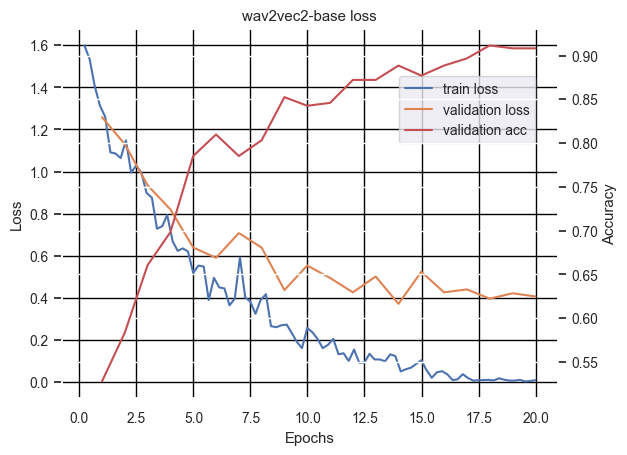

In [55]:
from matplotlib import pyplot as plt

model_name = config['name']
n_epochs = training_conf['num_train_epochs']

fig, ax = plt.subplots()

train_epochs, train_loss = zip(*extracted_values['loss'])
val_epochs, val_loss = zip(*extracted_values['eval_loss'])
val_acc_epochs, val_acc = zip(*extracted_values['eval_accuracy'])

chart1, = ax.plot(train_epochs, train_loss)
chart2, = ax.plot(val_epochs, val_loss)

ax_right = ax.twinx()
chart3, = ax_right.plot(val_acc_epochs, val_acc, 'r-')
ax_right.set_ylabel('Accuracy')

ax.set_facecolor('white')
ax.set_title(f'{model_name} loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
ax.grid(visible=True, alpha=1.0, color='black')
ax.legend([chart1, chart2, chart3], ['train loss', 'validation loss', 'validation acc'], loc=(.68, .69))

fig.savefig(f'Plots/{model_name}_{n_epochs}_loss')

In [9]:
from transformers import pipeline

classifier = pipeline("audio-classification", model=config['output_dir'])

Guess a random example

In [10]:
from random import randint

i = randint(0, len(encoded_dataset['test'])-1)
test_audio = encoded_dataset['test'][i]

scores = classifier(np.array(test_audio['input_values']))
print("Prediction:", scores[0])
print("True label:", id_to_labels[test_audio['label']])

Prediction: {'score': 0.9980637431144714, 'label': '06 Deep House'}
True label: 06 Deep House


Run classification on train and test audio data

In [14]:
from tqdm import tqdm

classifier_interface = lambda X: classifier(np.array(X['input_values']))

train_predictions = map(classifier_interface, encoded_dataset['train'])
train_scores = list(tqdm(train_predictions, total=len(encoded_dataset['train'])))

test_predictions = map(classifier_interface, encoded_dataset['test'])
test_scores = list(tqdm(test_predictions, total=len(encoded_dataset['test'])))

100%|██████████| 611/611 [03:53<00:00,  2.61it/s]


In [17]:
predicted_classes_train = [labels_to_id[max_score_element[0]['label']] for max_score_element in train_scores]
train_labels = encoded_dataset['train']['label']

predicted_classes_test = [labels_to_id[max_score_element[0]['label']] for max_score_element in test_scores]
test_labels = encoded_dataset['test']['label']

In [19]:
from sklearn.metrics import accuracy_score, f1_score

print(f"Accuracy for train set: {accuracy_score(y_pred=predicted_classes_train, y_true=train_labels)}")
print(f"F1 score for train set: {f1_score(y_pred=predicted_classes_train, y_true=train_labels, average='weighted')}")

print(f"Accuracy for test set: {accuracy_score(y_pred=predicted_classes_test, y_true=test_labels)}")
print(f"F1 score for test set: {f1_score(y_pred=predicted_classes_test, y_true=test_labels, average='weighted')}")

Accuracy for train set: 0.9978925184404637
F1 score for train set: 0.9978923239592277
Accuracy for test set: 0.9328968903436988
F1 score for test set: 0.9330419713757041


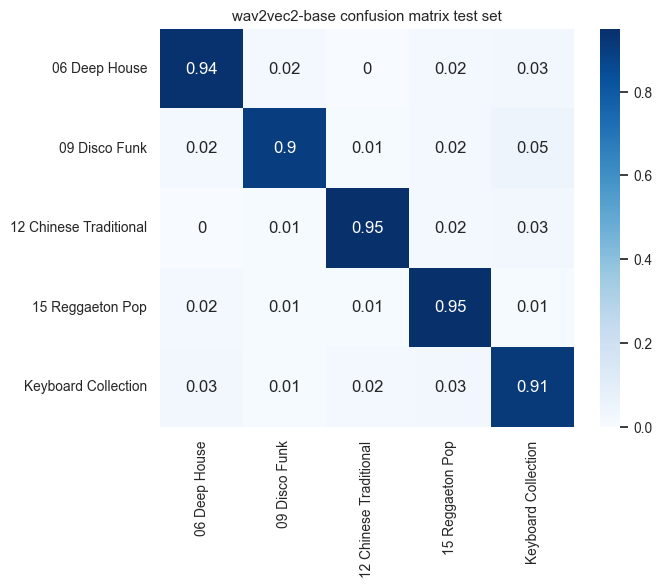

In [20]:
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
from lib_util import plot

epochs = 10

class_names = utils.get_class_names()

#Confusion matrix of the predicted labels versus the true labels
conf_mat = confusion_matrix(test_labels, predicted_classes_test, normalize= 'true')
conf_mat = np.round(conf_mat, 2)

conf_mat_df = DataFrame(conf_mat, columns=class_names, index=class_names)

plot.plot_conf_mat(conf_mat_df, save_to=f"Plots/{config['name']}_{epochs}_test_conf_mat.png", name=config['name'], set_type='test')